# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [2]:
def grab(x):
    return x.detach().numpy()

In [4]:
def compute_ess(w):
    return w.mean()**2 / (w**2).mean()

# Phi4 theory

Copied from Lecture 1:

In [5]:
class Phi4Action:
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
        self.grad = torch.func.grad(self.value)
    def value(self, phi):
        # phi.shape = (Lx, Ly, ...)
        Nd = len(phi.shape)
        S = ((Nd + self.m2/2) * phi**2 + (self.lam/24) * phi**4).sum()
        for mu in range(Nd):
            phi_fwd = torch.roll(phi, -1, dims=mu)
            S -= (phi * phi_fwd).sum()
        return S

In [6]:
def leapfrog_update(phi, pi, action, *, dt, n_leap):
    phi += (dt/2)*pi
    for _ in range(n_leap-1):
        pi -= dt*action.grad(phi)
        phi += dt*pi
    pi -= dt*action.grad(phi)
    phi += (dt/2)*pi

**TODO:** Modify to keep L as a parameter, and return samples $\phi$ and associated action values:

In [7]:
def run_hmc(action, *, L, n_therm, n_iter, n_meas, dt=0.10, n_leap=10):
    torch.manual_seed(1234)
    phi = 0.1*torch.randn((L, L)) # warm start
    S = action.value(phi)
    acc = 0
    tot = 0
    meas = []
    phis = []
    actions = []
    for i in tqdm.tqdm(range(-n_therm, n_iter)):
        new_phi = phi.clone()
        pi = torch.randn_like(phi)
        K = (pi**2/2).sum()
        leapfrog_update(new_phi, pi, action, dt=dt, n_leap=n_leap)
        Sp = action.value(new_phi)
        Kp = (pi**2/2).sum()
        dH = grab(Sp + Kp - S - K)
        tot += 1
        if np.random.random() < np.exp(-dH): # accept
            phi = new_phi
            S = Sp
            acc += 1
        if i >= 0 and (i+1)%n_meas == 0:
            meas.append(grab(phi.mean()))
            phis.append(grab(phi))
            actions.append(S)
            # print(f'Acc {100.0*acc/tot:.2f}')
    return dict(meas=np.stack(meas), phis=np.stack(phis), actions=np.stack(actions))

# Flow

In [17]:
class Velocity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        conv_kwargs = dict(kernel_size=3, padding_mode='circular', padding=1)
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(2, 8, **conv_kwargs),
            torch.nn.SiLU(),
            torch.nn.Conv2d(8, 8, **conv_kwargs),
            torch.nn.SiLU(),
            torch.nn.Conv2d(8, 1, **conv_kwargs)
        )
    def value(self, phi, t):
        return self.net(torch.stack([phi, t * torch.ones_like(phi)]))[0]

    def div(self, phi, t):
        shape = phi.shape
        phi_flat = phi.flatten()
        def eval_flat(y):
            phi = y.reshape(shape)
            inp = torch.stack([phi, torch.ones_like(phi)*t])
            return self.net(inp)[0].flatten()
        J = torch.func.jacfwd(eval_flat)(phi_flat)
        return torch.trace(J)

Copied from Lecture 2:

In [18]:
def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.tensor(0.0)
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x = x + sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ = logJ + dt * velocity.div(x, t)
    return x, logJ

In [19]:
flow_batch = torch.func.vmap(flow, in_dims=(0, None), chunk_size=512)

In [ ]:
# check L=4 hmc in broken phase

We will approach the target by learning 5 different flows trained to transport between the $m^2 = 0, \lambda = 1.5$ theory (symmetric phase) and the $m^2 = -0.5, \lambda = 1.5$ theory (broken phase) in steps of $m^2$:
$$
(m^2, \lambda) = (0, 1.5) \; \longrightarrow \; (-0.1, 1.5) \; \longrightarrow \; (-0.2, 1.5) \; \longrightarrow \; (-0.3, 1.5) \; \longrightarrow \; (-0.4, 1.5) \; \longrightarrow \; (-0.5, 1.5)
$$

In [20]:
targets = [Phi4Action(m2, 1.5) for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]]

In [21]:
def train_model(prior, target, *, batch_size=4, n_iter=1000):
    torch.manual_seed(1234)
    model = Velocity()
    L = 4
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    loss_hist = []
    ess_hist = []
    flow_batch = torch.func.vmap(flow, in_dims=(0, None))
    target_batch = torch.func.vmap(target.value)
    prior_batch = torch.func.vmap(prior.value)
    res_hmc = run_hmc(prior, L=L, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)
    prior_samples = res_hmc['phis']
    prior_actions = res_hmc['actions']
    for i in tqdm.tqdm(range(n_iter)):
        opt.zero_grad()
        # sample prior
        inds = np.random.randint(len(prior_samples), size=batch_size)
        xr = torch.tensor(prior_samples[inds])
        logr = -torch.tensor(prior_actions[inds])
        # flow
        x, logJ = flow_batch(xr, model, n_step=10)
        logp = -target_batch(x)
        # ordinary kl logq
        # logq = logr - logJ
        # path grad logq
        model.requires_grad_(False)
        xr2, logJ2 = flow_batch(x, model, n_step=10, inverse=True)
        model.requires_grad_(True)
        logq = -prior_batch(xr2) - logJ2
        # kl div
        loss = (logq - logp).mean()
        loss.backward()
        opt.step()
        loss_hist.append(grab(loss))
        ess = compute_ess((logp - logq).exp())
        ess_hist.append(grab(ess))
        if (i+1) % 25 == 0:
            print(f'Step {i+1}: Loss {grab(loss)} ESS {grab(ess)}')
    fig, axes = plt.subplots(1,2, figsize=(8, 3))
    axes[0].plot(loss_hist)
    axes[1].plot(ess_hist)
    axes[0].set_ylabel('loss')
    axes[1].set_ylabel('ess')
    return dict(model=model, loss=np.stack(loss_hist), ess=np.stack(ess_hist))

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.385822057723999 ESS 0.9832629561424255
Step 50: Loss -0.37834441661834717 ESS 0.9941146969795227
Step 75: Loss -0.3405795097351074 ESS 0.9712221026420593
Step 100: Loss -0.38668256998062134 ESS 0.9937248229980469
Step 125: Loss -0.36835575103759766 ESS 0.9936100840568542
Step 150: Loss -0.36866918206214905 ESS 0.9888554215431213
Step 175: Loss -0.34813567996025085 ESS 0.9936595559120178
Step 200: Loss -0.3672870397567749 ESS 0.9964891076087952


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.42758411169052124 ESS 0.9880919456481934
Step 50: Loss -0.46977460384368896 ESS 0.9768187403678894
Step 75: Loss -0.458954781293869 ESS 0.981904923915863
Step 100: Loss -0.45727235078811646 ESS 0.9825612902641296
Step 125: Loss -0.4213196039199829 ESS 0.983856737613678
Step 150: Loss -0.44233402609825134 ESS 0.9786126613616943
Step 175: Loss -0.41346031427383423 ESS 0.9887511134147644
Step 200: Loss -0.42934751510620117 ESS 0.983359158039093


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.5040737390518188 ESS 0.9334695935249329
Step 50: Loss -0.4982708692550659 ESS 0.9596703052520752
Step 75: Loss -0.4671274423599243 ESS 0.9564823508262634
Step 100: Loss -0.49337249994277954 ESS 0.957573413848877
Step 125: Loss -0.5269361138343811 ESS 0.9640464186668396
Step 150: Loss -0.5299595594406128 ESS 0.9665125012397766
Step 175: Loss -0.580844521522522 ESS 0.9719887971878052
Step 200: Loss -0.4561466574668884 ESS 0.9547422528266907


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.6637763977050781 ESS 0.9154109358787537
Step 50: Loss -0.6113002300262451 ESS 0.9178943037986755
Step 75: Loss -0.6553487777709961 ESS 0.9343088865280151
Step 100: Loss -0.6790633201599121 ESS 0.952278196811676
Step 125: Loss -0.7016345262527466 ESS 0.9396432042121887
Step 150: Loss -0.7492002248764038 ESS 0.9343401193618774
Step 175: Loss -0.6793764233589172 ESS 0.9547770023345947
Step 200: Loss -0.7002540826797485 ESS 0.9403780698776245


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.8791998028755188 ESS 0.8873345851898193
Step 50: Loss -0.8995232582092285 ESS 0.9257228374481201
Step 75: Loss -0.8877370357513428 ESS 0.9224796295166016
Step 100: Loss -0.8994230031967163 ESS 0.9266650080680847
Step 125: Loss -0.9214070439338684 ESS 0.9386754035949707
Step 150: Loss -0.9473026990890503 ESS 0.9259783029556274
Step 175: Loss -0.8618429899215698 ESS 0.8935643434524536
Step 200: Loss -0.7839940786361694 ESS 0.8765476942062378


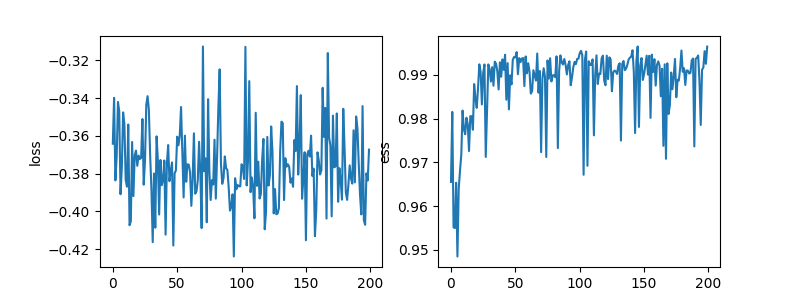

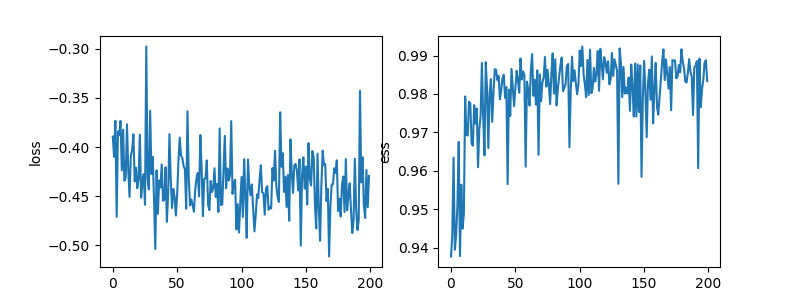

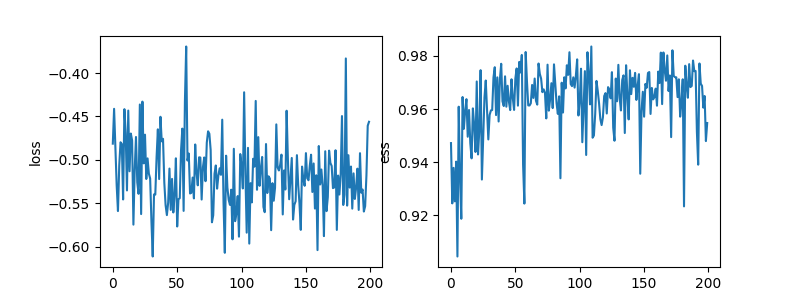

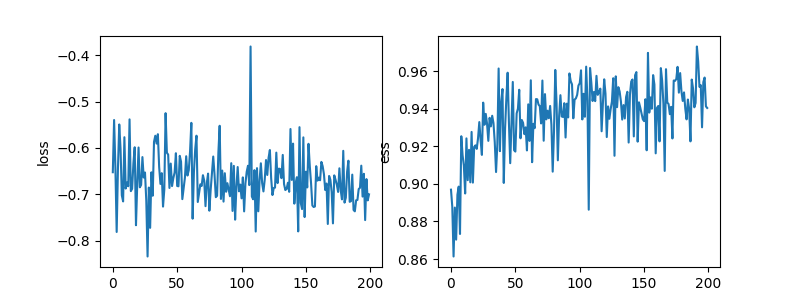

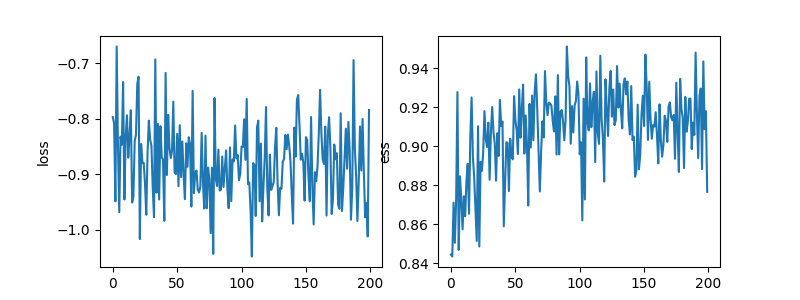

In [22]:
results = [
    train_model(targets[i], targets[i+1], batch_size=32, n_iter=200)
    for i in range(len(targets)-1)
]

# Evaluate

## L = 4

In [28]:
prior = Phi4Action(0.0, 1.5)
phi_r = torch.tensor(run_hmc(prior, L=4, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20)['phis'])
logr = -torch.func.vmap(prior.value)(phi_r)

  0%|          | 0/5100 [00:00<?, ?it/s]

In [29]:
def apply_flows(phi_r):
    samples = [phi_r]
    ws = [torch.ones(phi_r.shape[0])]
    for res, target_p, target in zip(tqdm.tqdm(results), targets[:-1], targets[1:]):
        with torch.no_grad(): # we don't need gradients, so don't waste memory for it
            phi, logJ = flow_batch(samples[-1].clone(), res['model'], n_step=100)
        dlogq = -logJ
        dlogp = -torch.func.vmap(target.value)(phi) + torch.func.vmap(target_p.value)(samples[-1])
        ws.append(ws[-1] * (dlogp - dlogq).exp())
        samples.append(phi)
        print(f'ess: {compute_ess(ws[-1])}')
    return dict(samples=samples, ws=ws)

In [30]:
res_L4 = apply_flows(phi_r)

  0%|          | 0/5 [00:00<?, ?it/s]

ess: 0.9930600523948669
ess: 0.9580017328262329
ess: 0.8583723902702332
ess: 0.6753415465354919
ess: 0.4614590108394623


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

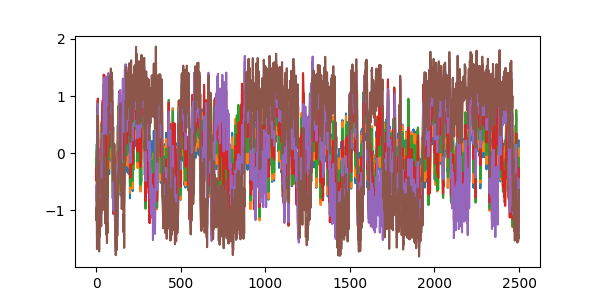

In [25]:
# compare with 2500 samples from the HMC
target = Phi4Action(-0.5, 1.5)
res_hmc_L4 = []
fig, ax = plt.subplots(1,1, figsize=(6, 3))
for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]:
    res_hmc_L4.append(run_hmc(Phi4Action(m2, 1.5), L=4, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20))
    ax.plot(res_hmc_L4[-1]['meas'])
plt.show()

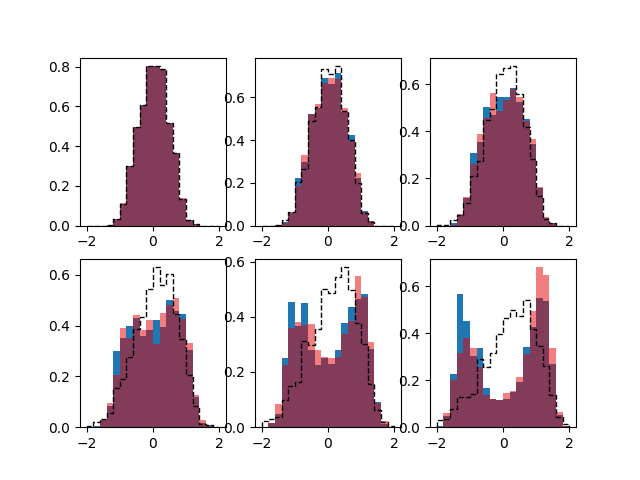

In [31]:
# plot it all
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, hmc in zip(axes, res_L4['samples'], res_L4['ws'], res_hmc_L4):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(hmc['meas'], density=True, bins=bins, alpha=0.5, color='xkcd:red')
plt.show()

## L = 8

Because we worked with convolutions, the _same_ flow model can be directly applied to the L=8 theory. The result is not great, but could be improved by scaling up the model, training more, and/or trying to build a specialized model to target the Z2 spontaneous symmetry breaking of the theory.